# IMPORTING and processing 100 Sentences 

In [1]:
import pandas as pd
import numpy as np
import nltk, itertools
from gensim.models import Word2Vec
import nltk, os
import tensorflow as tf
import itertools
import random

In [2]:
#taking the original dataset:

file_data = open('gh_create_all_fields_cleaned_data.txt', 'rt')
# reading the sentences:
sentences=file_data.read()
sentences=sentences.split('\n')

In [3]:
# randomly slicing through 50 sentences in the dataset:
train_sent=[]
for i in range(120):
    num = random.randrange(0, len(sentences))
    train_sent.append(sentences[num])



In [5]:
 out, inp = [" ".join(x.split()[1:]) for x in train_sent], [" ".join(x.split()[:1]) for x in train_sent]

# Converting the Code to an Acceptable format of Input:

In [6]:
table_map=dict()
out_map=dict()
## looping through all the indexing of the table names
for index, val in enumerate(out):
    table_map[inp[index]]=out[index]
    out_map[out[index]]=inp[index]
train_sent=[]
for key in table_map:
    sent="$"+key+"&"+" "+table_map[key]
    train_sent.append(sent)

# Code for Converting Index to Character and Character to Index

In [7]:
char_data =""

for sent in train_sent:
    char_data+=sent+"\n"

chars= list(set(char_data))

#create dictionary mapping for each char
char_to_ix = {ch:i for (i,ch) in enumerate(chars)}
ix_to_char = {i:ch for (i,ch) in enumerate(chars)}

# Get params for LSTM and RNN Algorithm Modules

In [8]:
def get_lstm_params(vocab_size, num_hiddens):
    num_inputs = num_outputs = vocab_size

    def normal(shape):
        return tf.random.normal(shape=shape, stddev=0.01, mean=0,
                                dtype=tf.float32)

    def three():
        return (tf.Variable(normal((num_inputs, num_hiddens)),
                            dtype=tf.float32),
                tf.Variable(normal((num_hiddens, num_hiddens)),
                            dtype=tf.float32),
                tf.Variable(tf.zeros(num_hiddens), dtype=tf.float32))

    W_xz, W_hz, b_z = three()  # Update gate parameters
    W_xr, W_hr, b_r = three()  # Reset gate parameters
    W_xh, W_hh, b_h = three()  # Candidate hidden state parameters
    # Output layer parameters
    W_hq = tf.Variable(normal((num_hiddens, num_outputs)), dtype=tf.float32)
    b_q = tf.Variable(tf.zeros(num_outputs), dtype=tf.float32)
    params = [W_xz, W_hz, b_z, W_xr, W_hr, b_r, W_xh, W_hh, b_h, W_hq, b_q]
    return params

In [10]:
# defining a function for getting all the parameters:
def get_rnn_params(vocab_size, num_hidden):
    num_inputs = num_outputs = vocab_size

    def normal(shape):
        return tf.random.normal(shape=shape,stddev=0.01,mean=0,dtype=tf.float32)

    # Hidden layer parameters
    E = tf.Variable(normal((vocab_size, 10)), dtype=tf.float32)
    W_xh = tf.Variable(normal((num_inputs, num_hiddens)), dtype=tf.float32)
    W_hh = tf.Variable(normal((num_hiddens, num_hiddens)), dtype=tf.float32)
    b_h = tf.Variable(tf.zeros(num_hiddens), dtype=tf.float32)
    # Output layer parameters
    W_hq = tf.Variable(normal((num_hiddens, num_outputs)), dtype=tf.float32)
    b_q = tf.Variable(tf.zeros(num_outputs), dtype=tf.float32)
    M = tf.Variable(tf.random.uniform([W_xh.shape[1], vocab_size], dtype=tf.float32))
    params = [W_xh, W_hh, b_h, W_hq, b_q, E, M]
#     params = [W_xh, W_hh, b_h, W_hq, b_q]
    return params

In [11]:
def tensorVectorConversion(arg):
    arg = tf.convert_to_tensor(arg, dtype=tf.float32)
    return arg

In [12]:
def init_gru_state(batch_size, num_hiddens):
    return (tf.zeros((batch_size, num_hiddens)),)

In [13]:
def init_rnn_state2(batch_size, num_hiddens):
    return (tf.zeros((batch_size, num_hiddens)), )


# Implementing the forward prop of both the LSTM and RNN

In [35]:
def rnn2(inputs, state, params, curr_sent, vocab_size, word2vec_model):
    # Here `inputs` shape: (`num_steps`, `batch_size`, `vocab_size`)
    W_xh, W_hh, b_h, W_hq, b_q,E, M = params
    
    # calculating the values from the encoder function
    result=tf.zeros([vocab_size, 1], tf.float32)
    for every_char in curr_sent:
        tfcharEmb = tensorVectorConversion(word2vec_model[every_char])
        tfcharEmb=tf.reshape(tfcharEmb, [10, 1])
        result+= tf.matmul(E, tfcharEmb)
        
#     M=tf.random.uniform([W_xh.shape[1], vocab_size], dtype=tf.float32)
    H, = state
    outputs = []
    # Shape of `X`: (`batch_size`, `vocab_size`)
    for X in inputs:
        
        
#         print("input",X.shape)
        X = tf.reshape(X,[-1,W_xh.shape[0]])
        a= tf.matmul(X, W_xh)
        b= tf.matmul(H, W_hh)
        c = tf.matmul(M, result)
        c =  tf.reshape(c, [c.shape[1], c.shape[0]])
        H = tf.nn.sigmoid(a + b + c + b_h, name='sigmoid')
        Y = tf.matmul(H, W_hq) + b_q
        y_out = tf.nn.softmax(Y)
#         print("Yshape",Y.shape)
        outputs.append(y_out)
    return tf.concat(outputs, axis=0), (H,)

In [36]:
def gru_train_forward_prop(inputs, state, params, vocab_size):
    W_xz, W_hz, b_z, W_xr, W_hr, b_r, W_xh, W_hh, b_h, W_hq, b_q = params
    H, = state
    outputs = []
    for X in inputs:
        X = tf.reshape(X, [-1, W_xh.shape[0]])
        Z = tf.sigmoid(tf.matmul(X, W_xz) + tf.matmul(H, W_hz) + b_z)
        R = tf.sigmoid(tf.matmul(X, W_xr) + tf.matmul(H, W_hr) + b_r)
        H_tilda = tf.tanh(tf.matmul(X, W_xh) + tf.matmul(R * H, W_hh) + b_h)
        H = Z * H + (1 - Z) * H_tilda
        Y = tf.matmul(H, W_hq) + b_q
        y_out = tf.nn.softmax(Y)
        outputs.append(y_out)
    return tf.concat(outputs, axis=0), (H,)



# Defining the LSTM and RNN modules

In [37]:
class RNNModelScratch2: #@save
    """A RNN Model implemented from scratch."""
    def __init__(self, vocab_size, num_hiddens,
                 init_state, forward_fn, word2vec):
        self.vocab_size, self.num_hiddens = vocab_size, num_hiddens
        self.init_state, self.forward_fn = init_state, forward_fn
        self.word2vec=word2vec

    def __call__(self, X, state, params, curr_sent):
        X = tf.one_hot(tf.transpose(X), self.vocab_size)
        X = tf.cast(X, tf.float32)
        return self.forward_fn(X, state, params, curr_sent, self.vocab_size, self.word2vec)

    def begin_state(self, batch_size):
        return self.init_state (batch_size, self.num_hiddens)
    

In [38]:
class LSTMModelScratch: #@save
    """A RNN Model implemented from scratch."""
    def __init__(self, vocab_size, num_hiddens,
                 init_state, forward_fn, word2vec):
        self.vocab_size, self.num_hiddens = vocab_size, num_hiddens
        self.init_state, self.forward_fn = init_state, forward_fn
        self.word2vec=word2vec

    def __call__(self, X, state, params, curr_sent):
        X = tf.one_hot(tf.transpose(X), self.vocab_size)
        X = tf.cast(X, tf.float32)
        return self.forward_fn(X, state, params, self.vocab_size)

    def begin_state(self, batch_size):
        return self.init_state (batch_size, self.num_hiddens)

# Different training modules for RNN and LSTM respectively

In [39]:
def train(model, params, table_map, char_to_ix, ix_to_char):
    "traing the modified model"
    state=None
    
    threshold = 0.05
    lr=1
    loss = tf.keras.losses.CategoricalCrossentropy()
    updater = tf.keras.optimizers.SGD(lr)
    optimizer = tf.keras.optimizers.Adam()
    loss_res=[] # storage for the resultant loss
    loss_epochs = [] #keeping of the loss per epoch
    epochs = 1200
#     metric = d2l.Accumulator(2)
#     timer=d2l.Timer()
    
    
    while epochs>0:
        
        loss_per_epoch=0
        
        for every_table in table_map:
            
            #padding the current word
            target_word = "$"+every_table+"&"
#             print("target word -> ",target_word)
            
            input_str = target_word[0:len(target_word)-1]
            target_str = target_word[1:len(target_word)]
            
            inputs = [char_to_ix[ch] for ch in input_str]
            targets = [char_to_ix[ch] for ch in target_str]
            
            X = tf.reshape(tf.Variable(inputs), (1, len(inputs)))
            Y_out = tf.reshape(tf.Variable(targets), (1, len(targets)))
            Y_true=tf.one_hot(Y_out, len(char_to_ix),on_value=1.0, off_value=0.0,axis=-1)
            Y_true=Y_true[0];
            
            
            # The actual crux of training the data:
            
            if state is None:
                
                state = model.begin_state(batch_size=X.shape[0])
                
            with tf.GradientTape(persistent=True) as g:
#                 print('I am here 1')
                g.watch(params)
                y_hat, state= model(X, state, params, table_map[every_table])
                y = tf.reshape(Y_out, (-1))
                axis_0 = np.shape(y_hat.numpy())[0]
                axis_1 = np.shape(y_hat.numpy())[1]
                Y_true=tf.reshape(Y_true, [axis_0, axis_1])
                # calculating the loss
                l = loss(Y_true, y_hat)
                
#             print(l)
            
#             print('I am here 2')
            grads = g.gradient(l, params)
            grads = grad_clipping(grads, 1)
            optimizer.apply_gradients(zip(grads, params))
#             updater.apply_gradients(zip(grads, params))
#             print('I am here 3')
#             metric.add(l * tf.size(y).numpy(), tf.size(y).numpy())
            loss_per_epoch=l
        
        if epochs%10==0:
            print("Total Epochs Covered: ", epochs, " Loss Value: ", loss_per_epoch)
            
        # after every epoch
        loss_epochs.append(loss_per_epoch)
#         loss_res.append(math.exp(metric[0] / metric[1]))
        epochs=epochs-1
    return loss_epochs


In [44]:
def train_network(model, params, table_map, char_to_ix, ix_to_char):
    "traing the modified model"
    state=None
    
    threshold = 0.05
    lr=0.01
    loss = tf.keras.losses.CategoricalCrossentropy()
    updater = tf.keras.optimizers.SGD(lr)
    optimizer = tf.keras.optimizers.Adam()
    loss_res=[] # storage for the resultant loss
    loss_epochs = [] #keeping of the loss per epoch
    epochs = 1200
    
    while epochs>0:
        
        loss_per_epoch=0
        
        for every_table in table_map:
            
            #padding the current word
            target_word = "$"+every_table+"&"
            
            input_str = target_word[0:len(target_word)-1]
            target_str = target_word[1:len(target_word)]
            
            inputs = [char_to_ix[ch] for ch in input_str]
            targets = [char_to_ix[ch] for ch in target_str]
            
            X = tf.reshape(tf.Variable(inputs), (1, len(inputs)))
            Y_out = tf.reshape(tf.Variable(targets), (1, len(targets)))
            Y_true=tf.one_hot(Y_out, len(char_to_ix),on_value=1.0, off_value=0.0,axis=-1)
            Y_true=Y_true[0];
            
            
            # The actual crux of training the data:
            
            if state is None:
                
                state = model.begin_state(batch_size=X.shape[0])
                
            with tf.GradientTape(persistent=True) as g:
#                 print('I am here 1')
                g.watch(params)
                y_hat, state= model(X, state, params, table_map[every_table])
                y = tf.reshape(Y_out, (-1))
                axis_0 = np.shape(y_hat.numpy())[0]
                axis_1 = np.shape(y_hat.numpy())[1]
                Y_true=tf.reshape(Y_true, [axis_0, axis_1])
                # calculating the loss
                l = loss(Y_true, y_hat)
            
            grads = g.gradient(l, params)
            grads = grad_clipping(grads, 1)
            optimizer.apply_gradients(zip(grads, params))
#             updater.apply_gradients(zip(grads, params))
#             metric.add(l * tf.size(y).numpy(), tf.size(y).numpy())
            loss_per_epoch=l
        
        if epochs%10==0:
            print("Total Epochs Covered: ", epochs, " Loss Value: ", loss_per_epoch)
        # after every epoch
        loss_epochs.append(loss_per_epoch)
#         loss_res.append(math.exp(metric[0] / metric[1]))
        epochs=epochs-1
    return loss_epochs

# Gradient Clipping Algorithm

In [45]:
def grad_clipping(grads, theta): #@save
    """Clip the gradient."""
    theta = tf.constant(theta, dtype=tf.float32)
    norm = tf.math.sqrt(sum((tf.reduce_sum(grad ** 2)).numpy()
                        for grad in grads))
#     print(norm)
    norm = tf.cast(norm, tf.float32)
    new_grad = []
    if tf.greater(norm, theta):
        for grad in grads:
            new_grad.append(grad * theta / norm)
    else:
        for grad in grads:
            new_grad.append(grad)
    return new_grad

# Defining the Character Embedding Module 

In [46]:
# functions to calculate word tokenizations and tokenizers:
# which would be later used for calculating the word to 

def filter_words(sentence):
    ll = [[nltk.word_tokenize(w), ' '] for w in sentence.split()]
#     print(list(itertools.chain(*list(itertools.chain(*ll)))))
#     return [word.lower() if word.isalpha() else " " for word in [nltk.word_tokenize(sentence), " "]]
    return list(itertools.chain(*list(itertools.chain(*ll))))

def tokenize(text):
    return [filter_words(sentence) for sentence in nltk.sent_tokenize(text)]


tokenized_words=[]
sent_data=[]
for sentence in out:
    sent_mod=''
    for char in sentence:
        sent_mod+=char+' ' 
#     print(sent_mod)
#     print(nltk.sent_tokenize(sent_mod))
    tokenized_words.extend(tokenize(sent_mod))
    sent_data.append(sentence)

word2vec_model = Word2Vec(tokenized_words, 
                          sg=1,  # here we will use skipgram 0 is for CBROW; skip gram is for smaller models 
                          size=10,
                          min_count=1 # word needs to occur atleast once
                         )



# RNN training

In [47]:
num_hiddens = 512        # declaration of number of hidden layers
lr=0.1                   # declaration of regularization parameter
seq_len=10               # this is a sequence length
updater = tf.keras.optimizers.SGD(lr)
# data_reader = DataReader("temp.txt", seq_len)
#defining the required params:
rnn_params = get_params2(len(chars), num_hiddens)

rnn_model=RNNModelScratch2(len(chars), num_hiddens, init_rnn_state2, rnn2, word2vec_model)
rnn_loss_res =train(rnn_model, rnn_params, table_map, char_to_ix, ix_to_char)

/Users/kedargn94/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  


Total Epochs Covered:  1200  Loss Value:  tf.Tensor(3.034361, shape=(), dtype=float32)
Total Epochs Covered:  1190  Loss Value:  tf.Tensor(3.4311976, shape=(), dtype=float32)
Total Epochs Covered:  1180  Loss Value:  tf.Tensor(2.918927, shape=(), dtype=float32)
Total Epochs Covered:  1170  Loss Value:  tf.Tensor(2.1391492, shape=(), dtype=float32)
Total Epochs Covered:  1160  Loss Value:  tf.Tensor(2.060493, shape=(), dtype=float32)
Total Epochs Covered:  1150  Loss Value:  tf.Tensor(2.6624956, shape=(), dtype=float32)
Total Epochs Covered:  1140  Loss Value:  tf.Tensor(2.8136683, shape=(), dtype=float32)
Total Epochs Covered:  1130  Loss Value:  tf.Tensor(1.2950535, shape=(), dtype=float32)
Total Epochs Covered:  1120  Loss Value:  tf.Tensor(1.170506, shape=(), dtype=float32)
Total Epochs Covered:  1110  Loss Value:  tf.Tensor(0.32068306, shape=(), dtype=float32)
Total Epochs Covered:  1100  Loss Value:  tf.Tensor(0.13825509, shape=(), dtype=float32)
Total Epochs Covered:  1090  Loss 

Total Epochs Covered:  280  Loss Value:  tf.Tensor(3.0196645e-05, shape=(), dtype=float32)
Total Epochs Covered:  270  Loss Value:  tf.Tensor(2.2293094e-05, shape=(), dtype=float32)
Total Epochs Covered:  260  Loss Value:  tf.Tensor(4.5776724e-06, shape=(), dtype=float32)
Total Epochs Covered:  250  Loss Value:  tf.Tensor(3.5240573e-05, shape=(), dtype=float32)
Total Epochs Covered:  240  Loss Value:  tf.Tensor(1.3566302e-05, shape=(), dtype=float32)
Total Epochs Covered:  230  Loss Value:  tf.Tensor(0.001371428, shape=(), dtype=float32)
Total Epochs Covered:  220  Loss Value:  tf.Tensor(3.5762793e-07, shape=(), dtype=float32)
Total Epochs Covered:  210  Loss Value:  tf.Tensor(2.7193257e-05, shape=(), dtype=float32)
Total Epochs Covered:  200  Loss Value:  tf.Tensor(1.7798624e-05, shape=(), dtype=float32)
Total Epochs Covered:  190  Loss Value:  tf.Tensor(5.0799328e-05, shape=(), dtype=float32)
Total Epochs Covered:  180  Loss Value:  tf.Tensor(2.6702937e-06, shape=(), dtype=float32)
T

# LSTM Training

In [49]:
 
num_hiddens = 512        # declaration of number of hidden layers
lr=0.1                   # declaration of regularization parameter
seq_len=10               # this is a sequence length
updater = tf.keras.optimizers.SGD(lr)
# data_reader = DataReader("temp.txt", seq_len)
#defining the required params:
params = get_lstm_params(len(chars), num_hiddens)

lstm_model=LSTMModelScratch(len(chars), num_hiddens, init_gru_state, gru_train_forward_prop, word2vec_model)
lstm_loss_res=train_network(lstm_model, params, table_map, char_to_ix, ix_to_char)



Total Epochs Covered:  1200  Loss Value:  tf.Tensor(3.0462298, shape=(), dtype=float32)
Total Epochs Covered:  1190  Loss Value:  tf.Tensor(1.8766019, shape=(), dtype=float32)
Total Epochs Covered:  1180  Loss Value:  tf.Tensor(0.9020842, shape=(), dtype=float32)
Total Epochs Covered:  1170  Loss Value:  tf.Tensor(0.008445079, shape=(), dtype=float32)
Total Epochs Covered:  1160  Loss Value:  tf.Tensor(0.011036928, shape=(), dtype=float32)
Total Epochs Covered:  1150  Loss Value:  tf.Tensor(0.0010914957, shape=(), dtype=float32)
Total Epochs Covered:  1140  Loss Value:  tf.Tensor(0.85484, shape=(), dtype=float32)
Total Epochs Covered:  1130  Loss Value:  tf.Tensor(0.0010865189, shape=(), dtype=float32)
Total Epochs Covered:  1120  Loss Value:  tf.Tensor(0.00035188496, shape=(), dtype=float32)
Total Epochs Covered:  1110  Loss Value:  tf.Tensor(0.00021869961, shape=(), dtype=float32)
Total Epochs Covered:  1100  Loss Value:  tf.Tensor(5.8368692e-05, shape=(), dtype=float32)
Total Epochs

Total Epochs Covered:  290  Loss Value:  tf.Tensor(1.1920929e-07, shape=(), dtype=float32)
Total Epochs Covered:  280  Loss Value:  tf.Tensor(1.1920929e-07, shape=(), dtype=float32)
Total Epochs Covered:  270  Loss Value:  tf.Tensor(1.1920929e-07, shape=(), dtype=float32)
Total Epochs Covered:  260  Loss Value:  tf.Tensor(1.1920929e-07, shape=(), dtype=float32)
Total Epochs Covered:  250  Loss Value:  tf.Tensor(1.1920929e-07, shape=(), dtype=float32)
Total Epochs Covered:  240  Loss Value:  tf.Tensor(1.1920929e-07, shape=(), dtype=float32)
Total Epochs Covered:  230  Loss Value:  tf.Tensor(1.1920929e-07, shape=(), dtype=float32)
Total Epochs Covered:  220  Loss Value:  tf.Tensor(1.1920929e-07, shape=(), dtype=float32)
Total Epochs Covered:  210  Loss Value:  tf.Tensor(1.1920929e-07, shape=(), dtype=float32)
Total Epochs Covered:  200  Loss Value:  tf.Tensor(1.1920929e-07, shape=(), dtype=float32)
Total Epochs Covered:  190  Loss Value:  tf.Tensor(1.1920929e-07, shape=(), dtype=float32)

# The Deep Learning Loss Function for Different Models (RNN and LSTM)

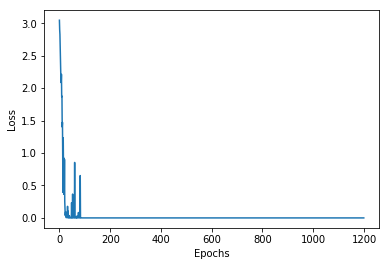

In [51]:
import matplotlib.pyplot as plt
plt.plot(lstm_loss_res)
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.show()

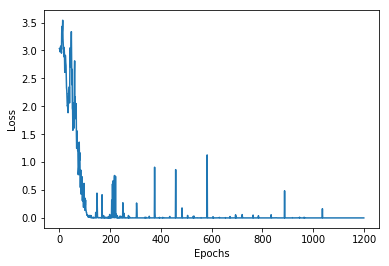

In [52]:
import matplotlib.pyplot as plt
plt.plot(rnn_loss_res)
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.show()

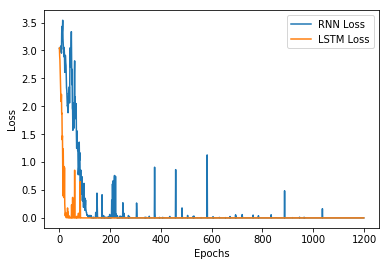

In [53]:
plt.plot(rnn_loss_res)
plt.plot(lstm_loss_res)
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend(["RNN Loss", "LSTM Loss"])
plt.show()


# Evaluating the Plot for the Test Data

In [69]:
def evaluate_TestData(model, params, table_map, char_to_ix, ix_to_char, eval_data):
    
    "traing the modified model"
    state=None
    
    threshold = 0.05
    lr=1
    loss = tf.keras.losses.CategoricalCrossentropy()
    updater = tf.keras.optimizers.SGD(lr)
    optimizer = tf.keras.optimizers.Adam()
    loss_res=[] # storage for the resultant loss
    loss_epochs = [] #keeping of the loss per epoch
    epochs = 1200
    
    loss_per_epoch=0

    for every_table in eval_data:

        #padding the current word
        target_word = "$"+every_table+"&"
        input_str = target_word[0:len(target_word)-1]
        target_str = target_word[1:len(target_word)]

        inputs = [char_to_ix[ch] for ch in input_str]
        targets = [char_to_ix[ch] for ch in target_str]

        X = tf.reshape(tf.Variable(inputs), (1, len(inputs)))
        Y_out = tf.reshape(tf.Variable(targets), (1, len(targets)))
        Y_true=tf.one_hot(Y_out, len(char_to_ix),on_value=1.0, off_value=0.0,axis=-1)
        Y_true=Y_true[0];


        # The actual crux of training the data:

        if state is None:

            state = model.begin_state(batch_size=X.shape[0])

        with tf.GradientTape(persistent=True) as g:
            g.watch(params)
            y_hat, state= model(X, state, params, table_map[every_table])
            y = tf.reshape(Y_out, (-1))
            axis_0 = np.shape(y_hat.numpy())[0]
            axis_1 = np.shape(y_hat.numpy())[1]
            Y_true=tf.reshape(Y_true, [axis_0, axis_1])
            # calculating the loss
            l = loss(Y_true, y_hat)


        loss_per_epoch=l

#     if epochs%10==0:
#         print("Total Epochs Covered: ", epochs, " Loss Value: ", loss_per_epoch)

    # after every epoch
        loss_epochs.append(loss_per_epoch)
    
    return loss_epochs
    

# Collecting the evaluation data:
    

In [70]:
eval_sent=[]

for _ in range(50):
    eval_sent.append(random.choice(inp))
    
len(eval_sent)

50

In [71]:
eval_loss_rnn = evaluate_TestData(rnn_model, rnn_params, table_map, char_to_ix, ix_to_char, eval_sent)

/Users/kedargn94/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  


In [72]:
eval_loss_lstm =evaluate_TestData(lstm_model, params, table_map, char_to_ix, ix_to_char, eval_sent)

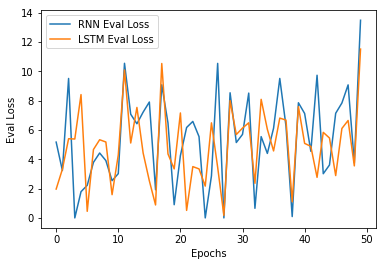

In [73]:


plt.plot(eval_loss_rnn)
plt.plot(eval_loss_lstm)
plt.ylabel('Eval Loss')
plt.xlabel('Epochs')
plt.legend(["RNN Eval Loss", "LSTM Eval Loss"])
plt.show()



In [ ]:
#Saving the LSTM and RNN params